## Interface to statsmodels: ARIMA time series models

This notebook provides a short exposition of how it is possible to interface with the cornucopia of time series models provided by the [statsmodels](https://www.statsmodels.org/stable/index.html) package. In this notebook, we illustrate how to fit the logistic ODE model, where the errors are described by ARIMA models.

In [1]:
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

## ARMA errors

We assume that the observed data $y(t)$ follows

$$y(t)= f(t; \theta) + \epsilon(t),$$

where $f(t; \theta)$ is the [logistic model](../toy/model-logistic.ipynb) solution.

Under the ARMA(1,1) noise model, the error terms $\epsilon(t)$ have 1 moving average term and 1 autoregressive term. Therefore, 

$$\epsilon(t) = \rho \epsilon(t-1) + \nu(t) + \phi \nu(t-1),$$

where the white noise term $\nu(t) \overset{i.i.d.}{\sim} \mathcal{N}(0, \sigma \sqrt{(1 - \rho^2) / (1 + 2 \rho \phi + \phi^2))}$. The noise process standard deviation is such that the marginal distribution of $\epsilon$ is,

$$\epsilon\sim\mathcal{N}(0, \sigma).$$

The ARMA(1,1) noise model is available in Pints using `pints.ARMA11LogLikelihood`. As before, the code below shows how to generate a time series with ARMA(1,1) noise and perform Bayesian inference using the Kalman filter provided by the statsmodels ARIMA module.

Note that, whilst we do not show how to do this, it is possible to use the `score` function of the [statsmodels](https://www.statsmodels.org/stable/index.html) package to calculate sensitivities of the log-likelihood.

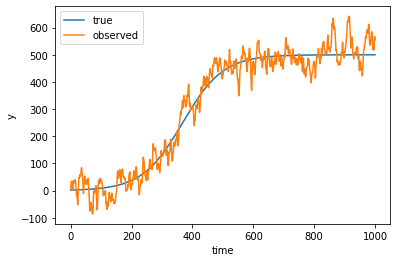

In [2]:
# Load a forward model
model = toy.LogisticModel()

# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 1000)
org_values = model.simulate(real_parameters, times)

# Add noise
noise = 10
rho = 0.9
phi = 0.95
## makes sigma comparable with estimate from statsmodel
errors = pints.noise.arma11(rho, phi, noise / np.sqrt((1-rho**2) / (1 + 2 * rho * phi + phi**2)), len(org_values))
values = org_values + errors

# Show the noisy data
plt.figure()
plt.plot(times, org_values)
plt.plot(times, values)
plt.xlabel('time')
plt.ylabel('y')
plt.legend(['true', 'observed'])
plt.show()

## Perform Bayesian inference using statsmodels' ARIMA Kalman filter

Here, we fit an ARMA(1,1) model in a Bayesian framework. Note, this is different from the `fit` functionality in the [statsmodels](https://www.statsmodels.org/stable/index.html) package, which estimates maximum likelihood parameter values.

In [3]:
from statsmodels.tsa.arima.model import ARIMA

model = toy.LogisticModel()

class ARIMALogLikelihood(pints.ProblemLogLikelihood):
    def __init__(self, problem, arima_order):
        super(ARIMALogLikelihood, self).__init__(problem)
        self._nt = len(self._times) - 1
        self._no = problem.n_outputs()
        
        if len(arima_order) != 3:
            raise ValueError("ARIMA (p, d, q) orders must be tuple of length 3.")
        self._arima_order = arima_order
        p = arima_order[0]
        d = arima_order[1]
        q = arima_order[2]
        self._p = p
        self._q = q
        self._d = d
        
        self._n_parameters = problem.n_parameters() + (p + q + 1) * self._no
        self._m = (self._p + self._q + 1) * self._no
    
    def __call__(self, x):
        # convert x to list to make it easier to append
        # nuisance params
        x = x.tolist()
        # p AR params; q MA params
        m = self._m
        
        # extract noise model params
        parameters = x[-m:]
        sol = self._problem.evaluate(x[:-m])
        model = ARIMA(endog=self._values,
                      order=self._arima_order,
                      exog=sol)
        # in statsmodels, parameters are variances
        # rather than std. deviations, so square
        sigma2 = parameters[-1]**2
        parameters = parameters[:-1] + [sigma2]
        
        # first param is trend (if model not differenced),
        # second is coefficient on ODE soln
        # see model.param_names
        if self._d == 0:
            full_params = [0, 1] + parameters
        else:
            full_params = [1] + parameters 
        return model.loglike(full_params)
    
# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = ARIMALogLikelihood(problem, arima_order=(1, 0, 1))

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [0.01, 400, 0, 0, noise * 0.1],
    [0.02, 600, 1, 1, noise * 100],
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Choose starting points for 3 mcmc chains
real_parameters = np.array(real_parameters + [rho, phi, 10])
xs = [
    real_parameters * 1.05,
    real_parameters * 1,
    real_parameters * 1.025
]

# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.HaarioBardenetACMC)

# Add stopping criterion
mcmc.set_max_iterations(4000)

# Disable logging
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

Running...
Done!


Look at results.

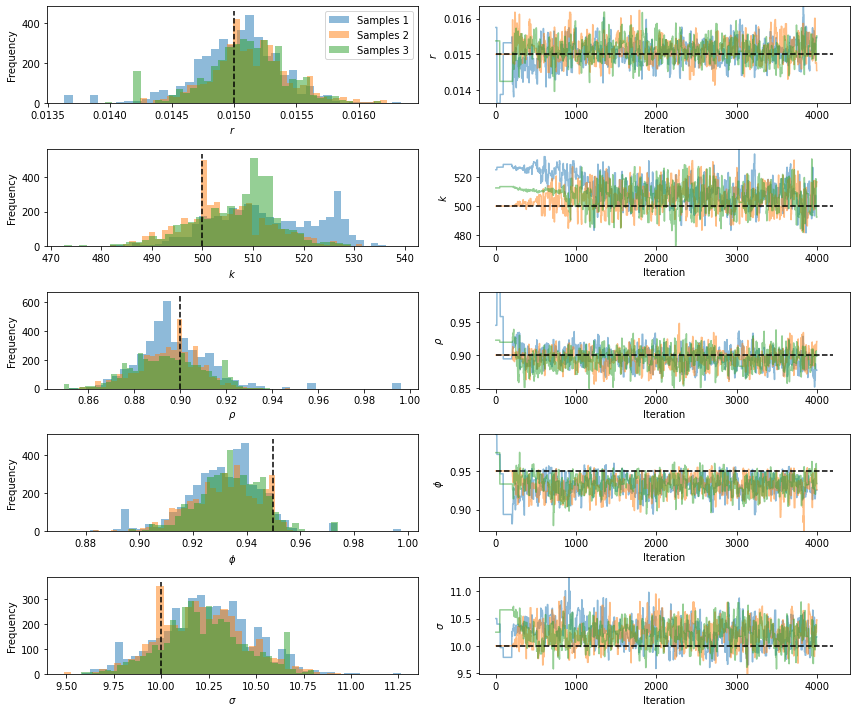

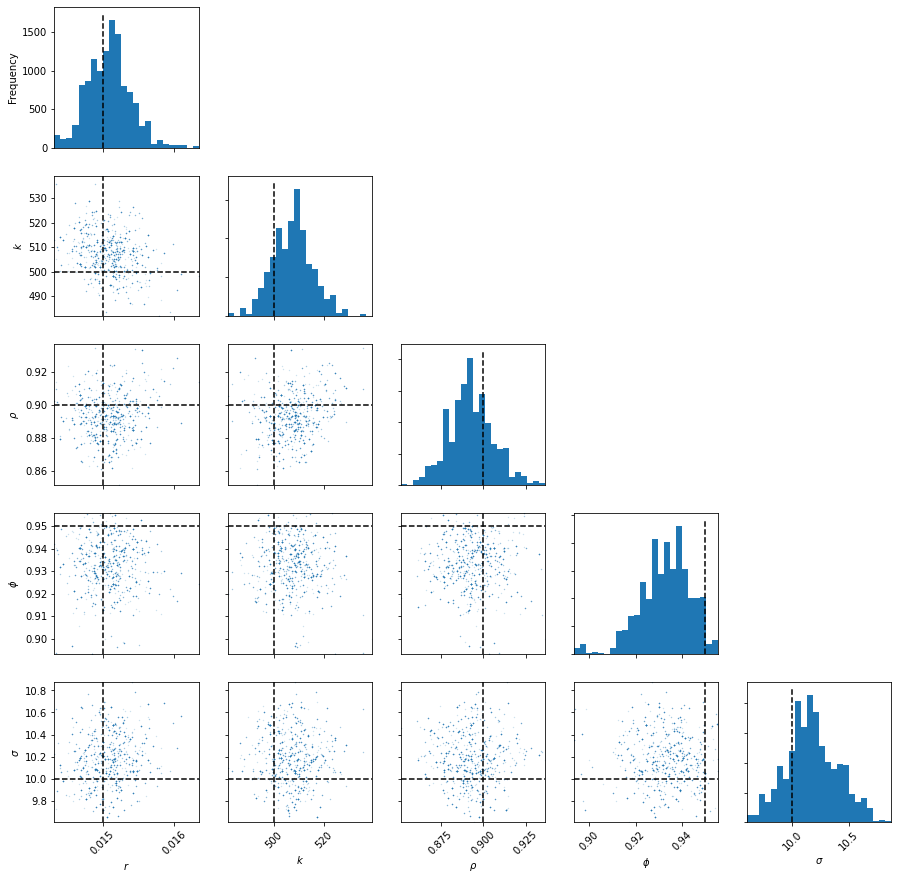

In [4]:
# Show traces and histograms
pints.plot.trace(chains,
                 ref_parameters=real_parameters,
                 parameter_names=[r'$r$', r'$k$', r'$\rho$', r'$\phi$', r'$\sigma$'])

# Discard warm up
chains = chains[:, 2000:, :]

# Look at distribution in chain 0
pints.plot.pairwise(chains[0],
                    kde=False,
                    ref_parameters=real_parameters,
                    parameter_names=[r'$r$', r'$k$', r'$\rho$', r'$\phi$', r'$\sigma$'])

# Show graphs
plt.show()

Look at results. Note that 'sigma' will be different to the value used to generate the data, due to a different definition.

In [6]:
results = pints.MCMCSummary(chains=chains,
                            parameter_names=["r", "k", "rho", "phi", "sigma"])
print(results)

param    mean    std.    2.5%    25%     50%     75%     97.5%    rhat    ess
-------  ------  ------  ------  ------  ------  ------  -------  ------  ------
r        0.02    0.00    0.01    0.01    0.02    0.02    0.02     1.01    364.88
k        506.26  8.89    489.33  500.18  506.60  512.27  524.52   1.01    284.43
rho      0.89    0.01    0.87    0.88    0.89    0.90    0.92     1.00    391.45
phi      0.93    0.01    0.91    0.93    0.93    0.94    0.95     1.01    334.78
sigma    10.21   0.22    9.76    10.07   10.20   10.36   10.64    1.01    385.04
